In [51]:
# WARNING: HDF5 FILES PRODUCED ON PERLMUTTER RETURN STRANGE VALUES ON CROSSOVER
# DO NOT USE rowe_stats.hdf5 DIRECTLY -- SAVE THE CONTENT AS A TXT FILE FIRST  
# AND THEN USE THAT TO MAKE PLOTS

#  Create combined catalog for running external check

In [48]:
import os,sys
import treecorr
import h5py
import numpy as np
from astropy.io import fits

def get_T_e1e2(d,colprefix,idx):
    ixx = d[1].data[colprefix+'_ixx'][idx]
    iyy = d[1].data[colprefix+'_iyy'][idx]
    ixy = d[1].data[colprefix+'_ixy'][idx]
    T   = ixx + iyy
    e1  = (ixx-iyy)/T
    e2  = 2*ixy/T
    return T,e1,e2

fieldlist = ['GAMA09H','GAMA15H','HECTOMAP', 'VVDS', 'WIDE12H', 'XMM']

dd       ={}

for stype in (['u','r']):

    ra  = np.array([])
    dec = np.array([])
    T_meas   = np.array([])
    T_model  = np.array([])
    e1_meas  = np.array([])
    e2_meas  = np.array([])
    e1_model = np.array([])
    e2_model = np.array([])
    idxr     = np.array([])
    idxu     = np.array([])
    
    dd[stype]={}
    print('__________',stype)
    for field in fieldlist:
        d = fits.open('/lcrc/project/SPT3G/users/ac.yomori/scratch/%s_stars.fits'%field)
        print('__________',field)
        if stype=='u': idx = np.where(d[1].data['icalib_psf_used']==True)[0]
        if stype=='r': idx = np.where(d[1].data['icalib_psf_used']==False)[0]
    
        uT_model, ue1_model, ue2_model = get_T_e1e2(d,'ishape_sdss_psf',idx)
        uT_meas, ue1_meas, ue2_meas    = get_T_e1e2(d,'ishape_sdss',idx);
    
        ra  = np.concatenate([ra ,  d[1].data['ira'][idx] ])
        dec = np.concatenate([dec,  d[1].data['idec'][idx] ])
        T_meas   = np.concatenate([T_meas,uT_meas])
        T_model  = np.concatenate([T_model,uT_model])
        e1_meas  = np.concatenate([e1_meas,ue1_meas])
        e2_meas  = np.concatenate([e2_meas,ue2_meas])
        e1_model = np.concatenate([e1_model,ue1_model])
        e2_model = np.concatenate([e2_model,ue2_model])
     
    dd[stype]['ra']=ra
    dd[stype]['dec']=dec
    dd[stype]['T_meas']=T_meas
    dd[stype]['T_model']=T_model
    dd[stype]['e1_meas']=e1_meas*0.5
    dd[stype]['e2_meas']=-e2_meas*0.5
    dd[stype]['e1_model']=e1_model*0.5
    dd[stype]['e2_model']=-e2_model*0.5
    


__________ u
__________ GAMA09H
__________ GAMA15H
__________ HECTOMAP
__________ VVDS
__________ WIDE12H
__________ XMM
__________ r
__________ GAMA09H
__________ GAMA15H
__________ HECTOMAP
__________ VVDS
__________ WIDE12H
__________ XMM


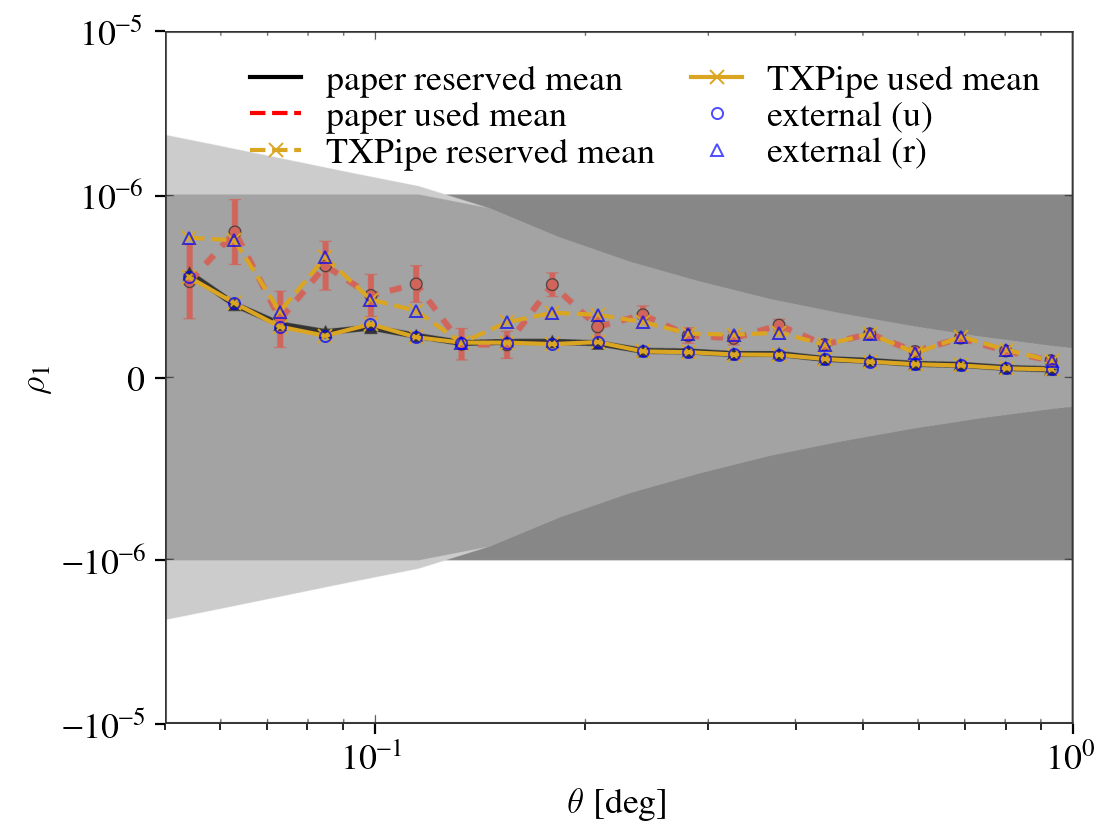

In [42]:
%matplotlib inline
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5))
img = plt.imread("rho1_bg.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim((0.05,1))
newax.set_ylim((-1e-5,1e-5))
newax.set_xlabel(r'$\theta\ [{\rm deg}]$')
newax.set_ylabel(r'$\rho_{1}$')
newax.set_xscale('log')
newax.set_yscale('symlog',linthresh=1e-6)
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().minorticks_off()

plt.plot([-11,-10],[1e3,1e3],'k',label='paper reserved mean')
plt.plot([-11,-10],[1e3,1e3],'r--',label='paper used mean')

tht,rowe1_r,rowe1_u=np.loadtxt('/lcrc/project/SPT3G/users/ac.yomori/repo/nulltests_txpipe/hscy1/rhostat/txpipe_hsc_rowe1.txt',unpack=True)
plt.semilogx(tht,rowe1_r,color='goldenrod',ls='--',label='TXPipe reserved mean',marker='x',ms=5 )
plt.semilogx(tht,rowe1_u,color='goldenrod',ls='-',label='TXPipe used mean',marker='x',ms=5)

for stype in (['u','r']):
    if stype=='u': mk='o'
    else: mk='^'
    corr  = treecorr.GGCorrelation(nbins=20, min_sep=3,max_sep=60, sep_units="arcmin", bin_slop=0)
    cat1  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=dd[stype]['e1_meas']-dd[stype]['e1_model'], g2=dd[stype]['e2_meas']-dd[stype]['e2_model'], ra_units="deg", dec_units="deg")
    cat2  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=dd[stype]['e1_meas']-dd[stype]['e1_model'], g2=dd[stype]['e2_meas']-dd[stype]['e2_model'], ra_units="deg", dec_units="deg")
    corr.process(cat1,cat2)
    plt.semilogx(np.exp(corr.meanlogr)*0.0166667, corr.xip,color='b',label='external (%s)'%stype,alpha=0.7,marker=mk,ms=4,mfc='None',ls='None')


plt.legend(ncol=2)

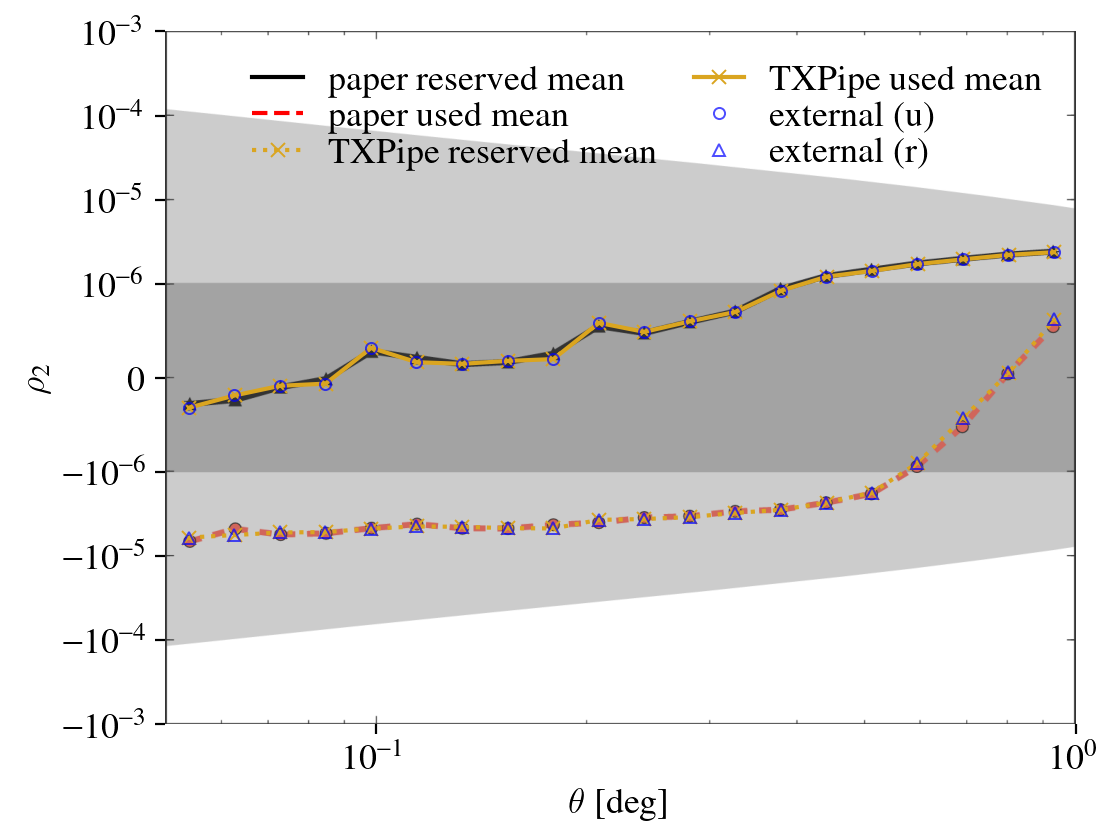

In [43]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5))
img = plt.imread("rho2_bg.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim((0.05,1))
newax.set_ylim((-1e-3,1e-3))
newax.set_xlabel(r'$\theta\ [{\rm deg}]$')
newax.set_ylabel(r'$\rho_{2}$')
newax.set_xscale('log')
newax.set_yscale('symlog',linthresh=1e-6)
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
#plot point

#newax.semilogx(tht,avg_rowe1_r/5,color='goldenrod',ls='--',label='avg (reserved)',marker='x',ms=5)
#newax.semilogx(tht,avg_rowe1_u/5,color='goldenrod',ls='-',label='avg (used)',marker='x',ms=5)
newax.plot([-11,-10],[1e3,1e3],'k',label='paper reserved mean')
newax.plot([-11,-10],[1e3,1e3],'r--',label='paper used mean')


tht,rowe2_r,rowe2_u=np.loadtxt('/lcrc/project/SPT3G/users/ac.yomori/repo/nulltests_txpipe/hscy1/rhostat/txpipe_hsc_rowe2.txt',unpack=True)
newax.semilogx(tht,rowe2_r,color='goldenrod',ls=':',label='TXPipe reserved mean',marker='x',ms=5 )
newax.semilogx(tht,rowe2_u,color='goldenrod',ls='-',label='TXPipe used mean',marker='x',ms=5)


for stype in (['u','r']):
    if stype=='u': mk='o'
    else: mk='^'
    corr  = treecorr.GGCorrelation(nbins=20, min_sep=3,max_sep=60, sep_units="arcmin", bin_slop=0)
    cat1  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=dd[stype]['e1_meas']-dd[stype]['e1_model'], g2=dd[stype]['e2_meas']-dd[stype]['e2_model'], ra_units="deg", dec_units="deg")
    cat2  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=dd[stype]['e1_model'], g2=dd[stype]['e2_model'], ra_units="deg", dec_units="deg")
    corr.process(cat1,cat2)
    plt.semilogx(np.exp(corr.meanlogr)*0.0166667, corr.xip,color='b',label='external (%s)'%stype,alpha=0.7,marker=mk,ms=4,mfc='None',ls='None')



plt.gca().minorticks_off()
plt.legend(ncol=2)

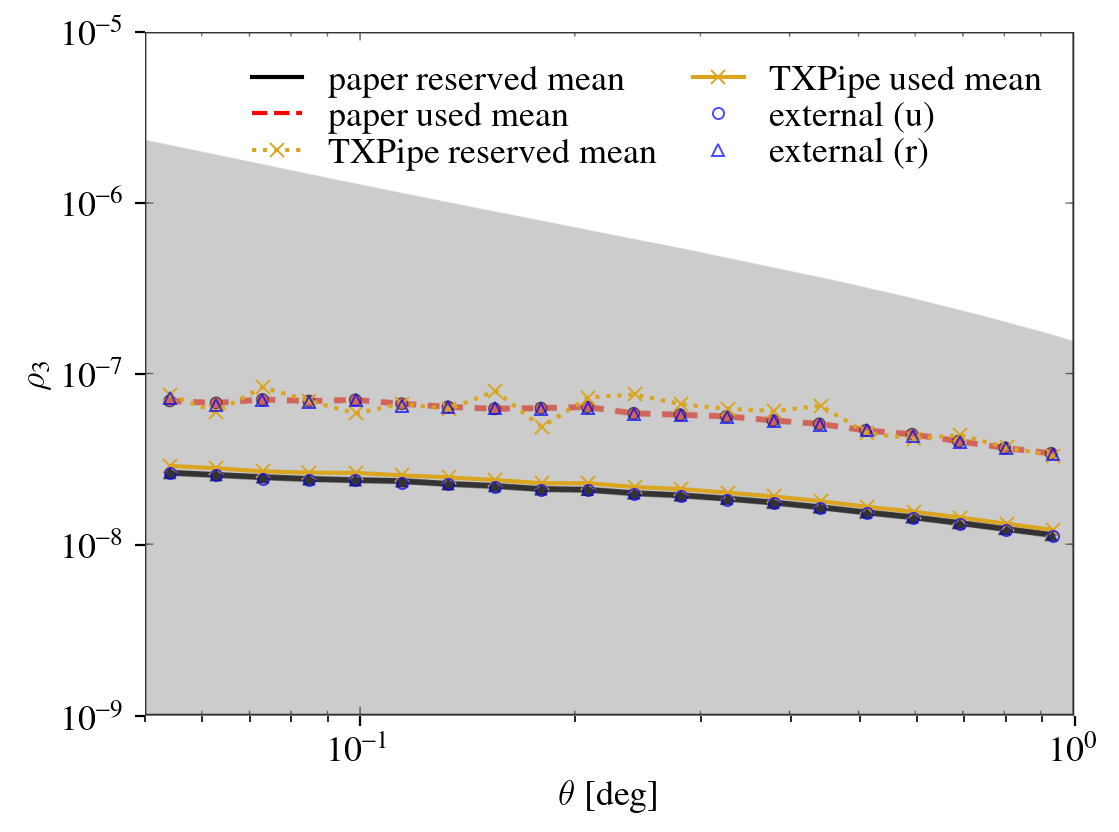

In [45]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5))
img = plt.imread("rho3_bg.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim((0.05,1))
newax.set_ylim((1e-9,1e-5))
newax.set_xlabel(r'$\theta\ [{\rm deg}]$')
newax.set_ylabel(r'$\rho_{3}$')
newax.set_xscale('log')
newax.set_yscale('log')

#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
#plot point

plt.gca().minorticks_off()
#plt.plot(a[:,0]*0.0166667,a[:,1],color='#165e83',marker='x',ms=5)   # VVDS

plt.plot([-11,-10],[1e3,1e3],'k',label='paper reserved mean')
plt.plot([-11,-10],[1e3,1e3],'r--',label='paper used mean')

tht,rowe3_r,rowe3_u=np.loadtxt('/lcrc/project/SPT3G/users/ac.yomori/repo/nulltests_txpipe/hscy1/rhostat/txpipe_hsc_rowe3.txt',unpack=True)
newax.semilogx(tht,rowe3_r,color='goldenrod',ls=':',label='TXPipe reserved mean',marker='x',ms=5 )
newax.semilogx(tht,rowe3_u,color='goldenrod',ls='-',label='TXPipe used mean',marker='x',ms=5)


for stype in (['u','r']):
    if stype=='u': mk='o'
    else: mk='^'
    g1m   = dd[stype]['e1_model']*( dd[stype]['T_meas']-dd[stype]['T_model'] )/dd[stype]['T_model']
    g2m   = dd[stype]['e2_model']*( dd[stype]['T_meas']-dd[stype]['T_model'] )/dd[stype]['T_model']
    
    corr  = treecorr.GGCorrelation(nbins=20, min_sep=3,max_sep=60, sep_units="arcmin", bin_slop=0)
    cat1  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=g1m, g2=g2m, ra_units="deg", dec_units="deg")
    cat2  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=g1m, g2=g2m, ra_units="deg", dec_units="deg")
    corr.process(cat1,cat2)
    plt.semilogx(np.exp(corr.meanlogr)*0.0166667, corr.xip,color='b',label='external (%s)'%stype,alpha=0.7,marker=mk,ms=4,mfc='None',ls='None')

plt.legend(ncol=2)

#################################################################
# Note: HSC uses e1_model*(T_meas-T_model)/T_model
# but DES uses e1_meas*(T_meas-T_model)/T_model, which is the 
# version implemented in TXPipe
#################################################################

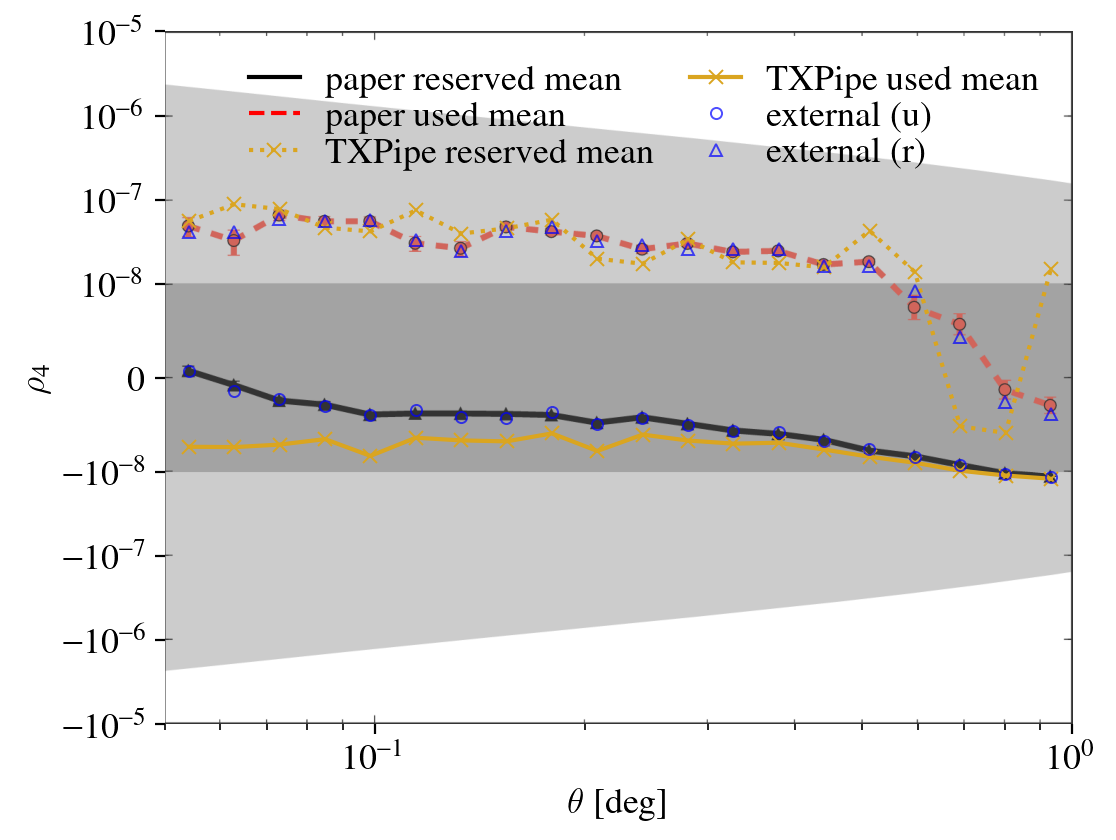

In [46]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5))
img = plt.imread("rho4_bg.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim((0.05,1))
newax.set_ylim((-1e-5,1e-5))
newax.set_xlabel(r'$\theta\ [{\rm deg}]$')
newax.set_ylabel(r'$\rho_{4}$')
newax.set_xscale('log')
newax.set_yscale('symlog',linthresh=1e-8)
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

plt.gca().minorticks_off()

plt.plot([-11,-10],[1e3,1e3],'k',label='paper reserved mean')
plt.plot([-11,-10],[1e3,1e3],'r--',label='paper used mean')


tht,rowe4_r,rowe4_u=np.loadtxt('/lcrc/project/SPT3G/users/ac.yomori/repo/nulltests_txpipe/hscy1/rhostat/txpipe_hsc_rowe4.txt',unpack=True)
newax.semilogx(tht,rowe4_r,color='goldenrod',ls=':',label='TXPipe reserved mean',marker='x',ms=5 )
newax.semilogx(tht,rowe4_u,color='goldenrod',ls='-',label='TXPipe used mean',marker='x',ms=5)

for stype in (['u','r']):
    if stype=='u': mk='o'
    else: mk='^'
    d1    = dd[stype]['e1_meas']-dd[stype]['e1_model']
    d2    = dd[stype]['e2_meas']-dd[stype]['e2_model']
    g1m   = dd[stype]['e1_model']*( dd[stype]['T_meas']-dd[stype]['T_model'] )/dd[stype]['T_model']
    g2m   = dd[stype]['e2_model']*( dd[stype]['T_meas']-dd[stype]['T_model'] )/dd[stype]['T_model']
    
    corr  = treecorr.GGCorrelation(nbins=20, min_sep=3,max_sep=60, sep_units="arcmin", bin_slop=0)
    cat1  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=d1, g2=d2, ra_units="deg", dec_units="deg")
    cat2  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=g1m, g2=g2m, ra_units="deg", dec_units="deg")
    corr.process(cat1,cat2)
    plt.semilogx(np.exp(corr.meanlogr)*0.0166667, corr.xip,color='b',label='external (%s)'%stype,alpha=0.7,marker=mk,ms=4,mfc='None',ls='None')

plt.legend(ncol=2)

#################################################################
# Note: HSC uses e1_model*(T_meas-T_model)/T_model
# but DES uses e1_meas*(T_meas-T_model)/T_meas, which is the 
# version implemented in TXPipe
#################################################################


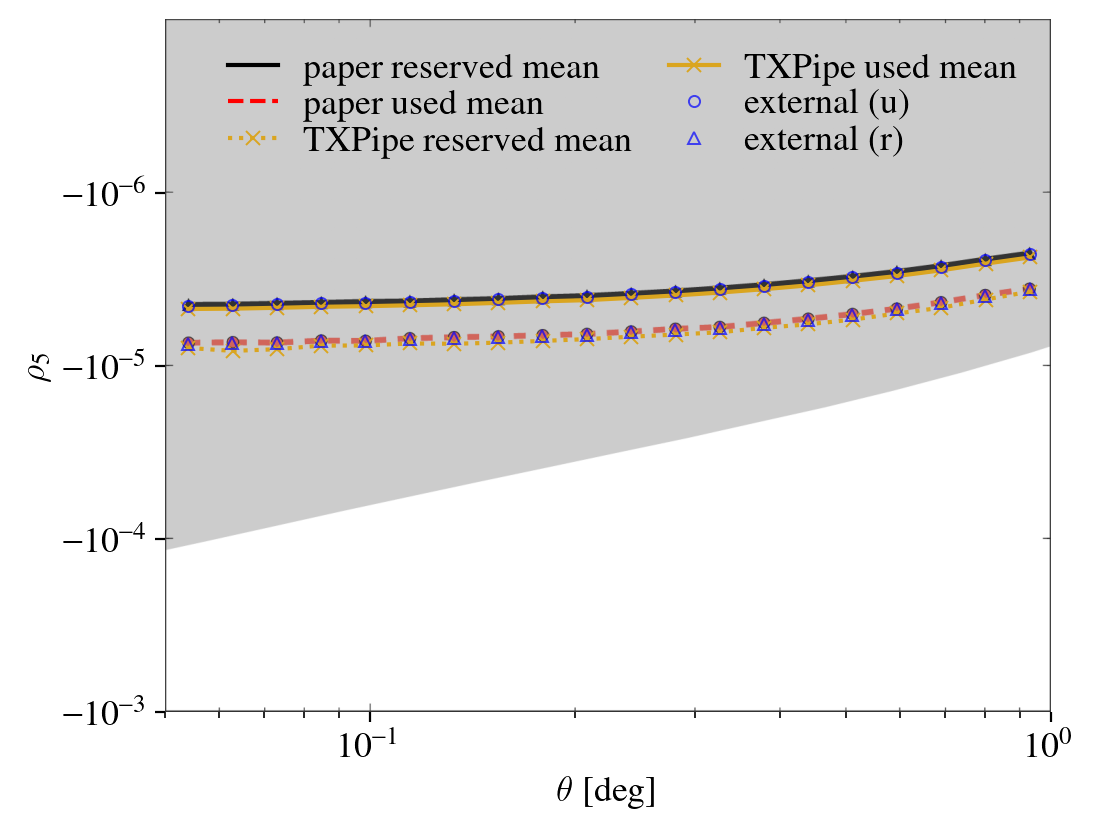

In [47]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5))
img = plt.imread("rho5_bg.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim((0.05,1))
newax.set_ylim((-1e-3,-1e-7))
newax.set_xlabel(r'$\theta\ [{\rm deg}]$')
newax.set_ylabel(r'$\rho_{5}$')
newax.set_xscale('log')
newax.set_yscale('symlog',linthresh=1e-6)
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
#plot point

plt.gca().minorticks_off()

plt.plot([-11,-10],[1e3,1e3],'k',label='paper reserved mean')
plt.plot([-11,-10],[1e3,1e3],'r--',label='paper used mean')

tht,rowe5_r,rowe5_u=np.loadtxt('/lcrc/project/SPT3G/users/ac.yomori/repo/nulltests_txpipe/hscy1/rhostat/txpipe_hsc_rowe5.txt',unpack=True)
newax.semilogx(tht,rowe5_r,color='goldenrod',ls=':',label='TXPipe reserved mean',marker='x',ms=5 )
newax.semilogx(tht,rowe5_u,color='goldenrod',ls='-',label='TXPipe used mean',marker='x',ms=5)

for stype in (['u','r']):
    if stype=='u': mk='o'
    else: mk='^'
    g1    = dd[stype]['e1_model']
    g2    = dd[stype]['e2_model']
    g1m   = dd[stype]['e1_model']*( dd[stype]['T_meas']-dd[stype]['T_model'] )/dd[stype]['T_model']
    g2m   = dd[stype]['e2_model']*( dd[stype]['T_meas']-dd[stype]['T_model'] )/dd[stype]['T_model']
    
    corr  = treecorr.GGCorrelation(nbins=20, min_sep=3,max_sep=60, sep_units="arcmin", bin_slop=0)
    cat1  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=g1, g2=g2, ra_units="deg", dec_units="deg")
    cat2  = treecorr.Catalog(ra=dd[stype]['ra'], dec=dd[stype]['dec'], g1=g1m, g2=g2m, ra_units="deg", dec_units="deg")
    corr.process(cat1,cat2)
    plt.semilogx(np.exp(corr.meanlogr)*0.0166667, corr.xip,color='b',label='external (%s)'%stype,alpha=0.7,marker=mk,ms=4,mfc='None',ls='None')

plt.legend(ncol=2)

#################################################################
# Note: HSC uses e1_model*(T_meas-T_model)/T_model
# but DES uses e1_meas*(T_meas-T_model)/T_meas, which is the 
# version implemented in TXPipe
#################################################################
